In [18]:
# %% [markdown]
# ## Setup

%matplotlib inline

from pathlib import Path
import re, math
from typing import Optional, List, Dict

import pandas as pd
import matplotlib.pyplot as plt

# User‑editable settings
CSV_CANDIDATES = [
    "./x_down_info_2.csv",
    "./x_down_info.csv",
    "/mnt/data/x_down_info_2.csv",
    "/mnt/data/x_down_info.csv",
]
ALTITUDES_KM = [500.0, 600.0]
ELEV_STEP_DEG = 5
OUTPUT_DIR = Path(".")  # change to a folder of your choice, e.g., Path("./out")

# For reproducible figures
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 110

In [19]:
# %% [markdown]
# ## Helpers

EARTH_RADIUS_KM = 6371.0

def resolve_csv_path(candidates: List[str]) -> str:
    for p in candidates:
        if Path(p).is_file():
            return p
    raise FileNotFoundError("CSV not found. Update CSV_CANDIDATES or place the file next to this notebook.")

def to_float(x) -> Optional[float]:
    if x is None:
        return None
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return None
    s = s.replace("%", "")
    m = re.match(r"^\s*([+-]?\d+(\.\d+)?)\s*(k|M|G)?\s*(bps|bit/s)?\s*$", s, re.IGNORECASE)
    if m:
        val = float(m.group(1))
        scale = m.group(3)
        if scale:
            if scale.lower() == "k": val *= 1e3
            elif scale.lower() == "m": val *= 1e6
            elif scale.lower() == "g": val *= 1e9
        return val
    try:
        return float(s)
    except Exception:
        return None

def sanitize_name(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9\-_.]+", "_", str(name)).strip("_")

def resolve_radio_columns(df: pd.DataFrame, pv_col: str) -> List[str]:
    meta = {pv_col, "parameter", "units", "unit", "formula", "notes", "note", "description"}
    candidates = [c for c in df.columns if c.lower() not in meta and c != pv_col and "(db" not in c.lower()]
    core = {"selected_carrier_frequency", "tx_power", "peak_boresight_antenna_gain", "g_t", "data_rate_in_db_hz"}
    keep = []
    for col in candidates:
        present = df[df[pv_col].isin(core)][col].astype(str).str.strip().ne("").sum()
        if present >= 3:
            keep.append(col)
    return keep

def get_var(df: pd.DataFrame, pv_col: str, varname: str, col: str, default=None):
    s = df.loc[df[pv_col] == varname, col]
    if s.empty:
        return default
    v = to_float(s.iloc[0])
    return v if v is not None else default

def get_var_any(df: pd.DataFrame, pv_col: str, varnames: List[str], col: str, default=None):
    for vn in varnames:
        s = df.loc[df[pv_col].str.lower() == vn.lower(), col]
        if not s.empty:
            v = to_float(s.iloc[0])
            if v is not None:
                return v
    token = re.split(r"[_\s]+", varnames[0])[0]
    m = df[df[pv_col].str.contains(token, case=False, na=False)]
    if not m.empty:
        v = to_float(m.iloc[0][col])
        if v is not None:
            return v
    return default

def slant_range_km(alt_km: float, elev_deg: float) -> float:
    e = math.radians(elev_deg)
    R = EARTH_RADIUS_KM
    H = R + alt_km
    return -R * math.sin(e) + math.sqrt((R * math.sin(e)) ** 2 + H ** 2 - R ** 2)

def fspl_db(range_km: float, freq_ghz: float) -> float:
    return 92.45 + 20 * math.log10(max(range_km, 1e-9)) + 20 * math.log10(freq_ghz)

def eirp_dbw(P_w: float, G_tx_dbi: float, L_tx_db: float) -> float:
    return 10 * math.log10(P_w) + (G_tx_dbi or 0.0) - (L_tx_db or 0.0)

def cn0_dbhz(eirp_dbw_val: float, L_total_db: float, G_T_dbk: float,
             k_val: float = 1.38e-23, extra_losses_db: float = 0.0) -> float:
    k_db = 10 * math.log10(k_val)
    return eirp_dbw_val - L_total_db + (G_T_dbk or 0.0) - k_db - (extra_losses_db or 0.0)

def pfd_dbw_per_m2(eirp_dbw_val: float, range_km: float) -> float:
    r_m = max(range_km * 1000.0, 1e-3)
    return eirp_dbw_val - 10 * math.log10(4 * math.pi * r_m * r_m)

,radio,atm_dB_used,rain_dB_used,scint_dB_used,pol_dB_used,other_dB_used,atm_dB_csv,rain_dB_csv,scint_dB_csv,pol_dB_csv,other_dB_csv
0,Endurosat,1.0,0.5,1.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0
1,SAIT,1.0,0.5,1.0,1.0,1.0,1.0,0.5,1.0,0.5,1.0


,radio,orbit_altitude_km,elevation_deg,slant_range_km,fspl_db,total_prop_loss_db,eirp_dbw,cn0_dbhz,ebn0_db,link_margin_db,pfd_dbw_per_m2
0,Endurosat,500.0,0,2573.130389,178.956672,183.456672,20.5103,88.274837,8.784837,1.394837,-118.691035
1,Endurosat,500.0,5,2077.091666,177.096550,181.596550,20.5103,90.134959,10.644959,3.254959,-116.830912
2,Endurosat,500.0,10,1694.567221,175.328612,179.828612,20.5103,91.902897,12.412897,5.022897,-115.062975
3,Endurosat,500.0,15,1407.203648,173.714575,178.214575,20.5103,93.516934,14.026934,6.636934,-113.448938
4,Endurosat,500.0,20,1192.797199,172.278769,176.778769,20.5103,94.952741,15.462741,8.072741,-112.013131
5,Endurosat,500.0,25,1031.819307,171.019509,175.519509,20.5103,96.212000,16.722000,9.332000,-110.753872
6,Endurosat,500.0,30,909.424938,169.922774,174.422774,20.5103,97.308736,17.818736,10.428736,-109.657136
7,Endurosat,500.0,35,815.037878,168.970992,173.470992,20.5103,98.260517,18.770517,11.380517,-108.705355
8,Endurosat,500.0,40,741.292866,168.147233,172.647233,20.5103,99.084276,19.594276,12.204276,-107.881595
9,Endurosat,500.0,45,683.068620,167.436723,171.936723,20.5103,99.794786,20.304786,12.914786,-107.171085


[info] Combined results saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\all_radios_link_PFD_vs_elevation_step5__custom_losses.csv


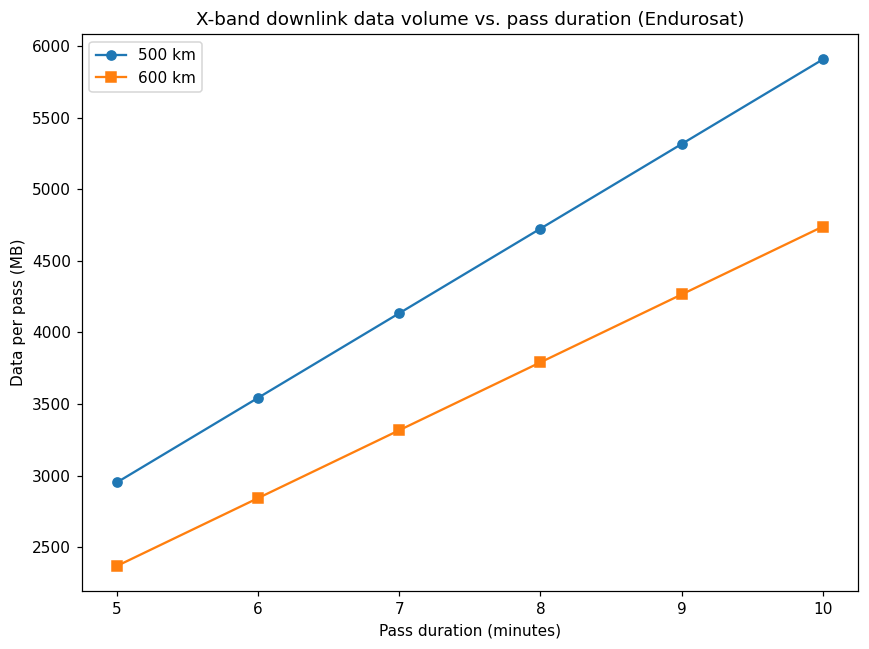

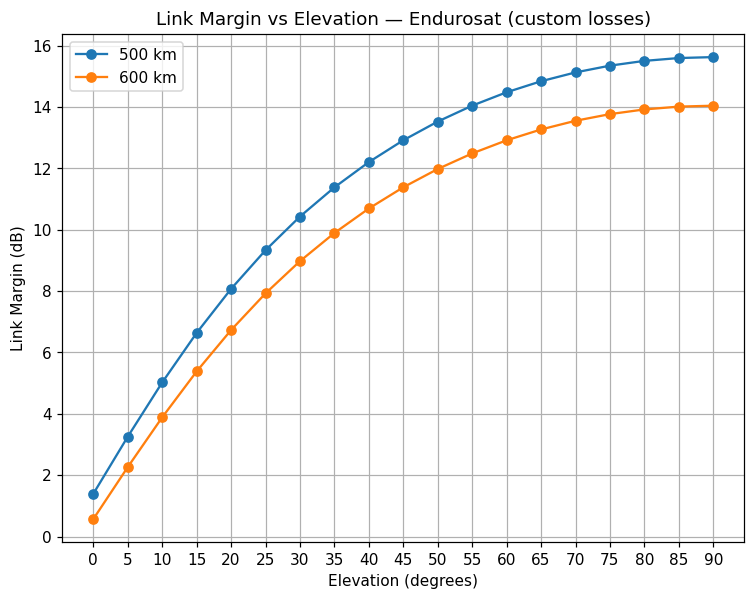

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_link_margin_vs_elevation_step5__custom_losses.png


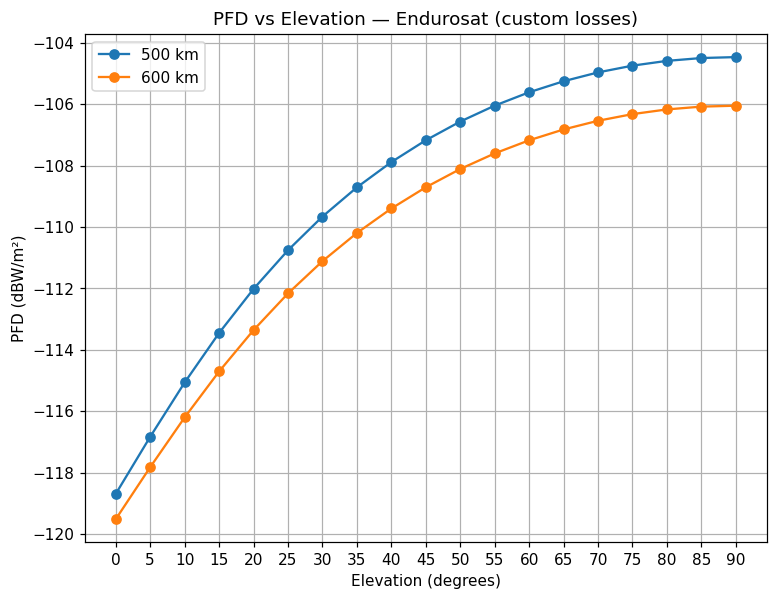

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_pfd_vs_elevation_step5__custom_losses.png


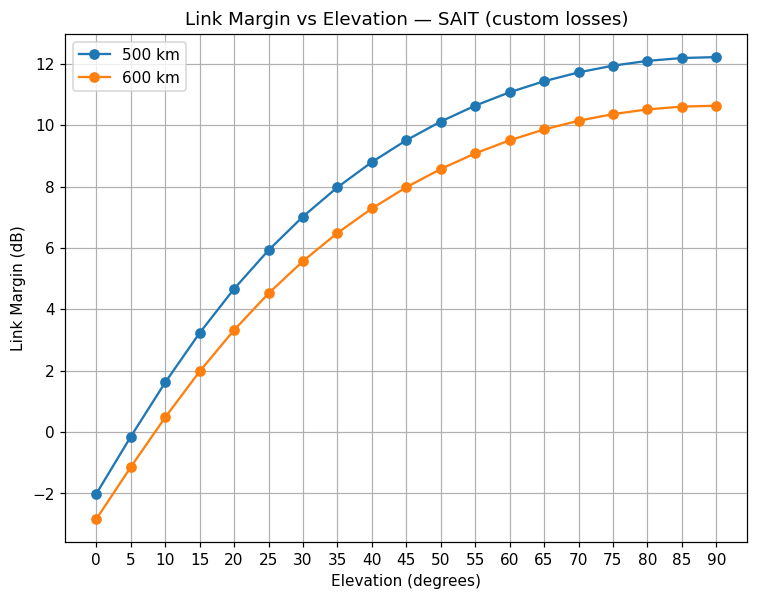

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_link_margin_vs_elevation_step5__custom_losses.png


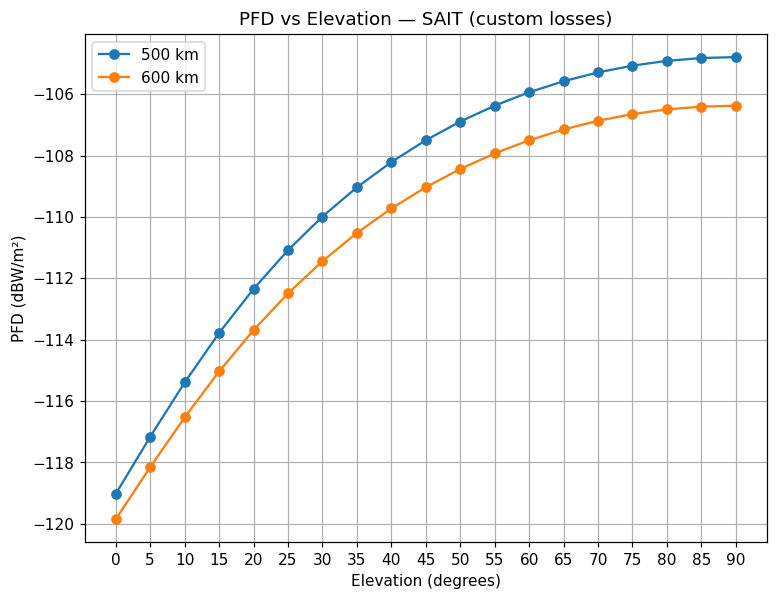

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_pfd_vs_elevation_step5__custom_losses.png


In [20]:
# %% [markdown]
# ## Override propagation losses (Atmospheric / Rain / Scintillation / Polarisation / Other)
#
# Use the OVERRIDES dict below to reduce (or increase) the default CSV losses.
# - Set a value (e.g., 0.2) to override that loss (in dB).
# - Set to None to keep the CSV's value for that field.
#
# Two layers are supported:
#   1) OVERRIDES["global"] applies to all radios
#   2) OVERRIDES["per_radio"]["<RadioName>"] overrides the global for that radio
#
# Outputs:
# - combined CSV:  all_radios_link_PFD_vs_elevation_step5__custom_losses.csv
# - per-radio CSV: <RADIO>_link_PFD_vs_elevation_step5__custom_losses.csv
# - per-radio PNGs: *_link_margin_vs_elevation_step5__custom_losses.png, *_pfd_vs_elevation_step5__custom_losses.png

# --- EDIT THESE VALUES ---
OVERRIDES = {
    "global": {
        "atmospheric_attenuation": 1.0,     # dB (e.g., reduce from 1.0 → 0.3); set None to keep CSV
        "rain_attenuation": 0.5,            # dB
        "scintillation_loss": 1.0,          # dB
        "polarisation_loss": 1.0,           # dB
        "other_propagation_losses": 1.0,    # dB
    },
    "per_radio": {
        # Example: "Endurosat": {"rain_attenuation": 0.2, "polarisation_loss": 0.2},
        #          "SAIT": {"atmospheric_attenuation": 0.2}
    }
}
# -------------------------

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reuse your notebook's constants if present; otherwise set fallbacks
try:
    ALTITUDES_KM
except NameError:
    ALTITUDES_KM = [500.0, 600.0]
try:
    ELEV_STEP_DEG
except NameError:
    ELEV_STEP_DEG = 5
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = Path(".")

# 1) Load CSV + detect radios
csv_path = resolve_csv_path(CSV_CANDIDATES)
df = pd.read_csv(csv_path)
pv_cols = [c for c in df.columns if c.strip().lower() == "python_variable"]
if not pv_cols:
    raise RuntimeError("Could not find a 'python_variable' column in the CSV.")
pv_col = pv_cols[0]
radios = resolve_radio_columns(df, pv_col)
if not radios:
    raise RuntimeError("No radio columns detected.")

# 2) Helper: choose effective loss value (CSV → global override → per-radio override)
def effective_loss(varname: str, radio: str, csv_val: float | None) -> float:
    val = csv_val
    gl = OVERRIDES.get("global", {})
    if gl.get(varname) is not None:
        val = gl[varname]
    pr = OVERRIDES.get("per_radio", {}).get(radio, {})
    if pr.get(varname) is not None:
        val = pr[varname]
    return 0.0 if val is None else float(val)

# 3) Build elevation grid and compute with overrides
elevations = list(range(0, 91, ELEV_STEP_DEG))
records = []
used_losses_rows = []

for radio in radios:
    # Required (unchanged)
    f_ghz = get_var(df, pv_col, "selected_carrier_frequency", radio, None)
    tx_power_w = get_var(df, pv_col, "tx_power", radio, None)
    Gtx_dbi = get_var(df, pv_col, "peak_boresight_antenna_gain", radio, None)
    G_T = get_var(df, pv_col, "g_t", radio, None)
    Rb_dBHz = get_var(df, pv_col, "data_rate_in_db_hz", radio, None)

    # Optional (unchanged)
    Ltx_db = get_var_any(df, pv_col, ["interconnect_losses_gains", "interconnect_loss"], radio, 0.0)
    EbN0_req = get_var(df, pv_col, "codmod_inferred_required_eb_n0", radio, 0.0)
    other_overall = get_var(df, pv_col, "other_overall_link_losses", radio, 0.0)
    rolloff = get_var(df, pv_col, "gain_rolloff_loss_at_pointing_error", radio, 0.0)

    # CSV losses
    atm_csv  = get_var(df, pv_col, "atmospheric_attenuation", radio, 0.0)
    rain_csv = get_var(df, pv_col, "rain_attenuation", radio, 0.0)
    scint_csv= get_var(df, pv_col, "scintillation_loss", radio, 0.0)
    pol_csv  = get_var(df, pv_col, "polarisation_loss", radio, 0.0)
    oth_csv  = get_var(df, pv_col, "other_propagation_losses", radio, 0.0)

    # Effective (with overrides)
    atm   = effective_loss("atmospheric_attenuation",   radio, atm_csv)
    rain  = effective_loss("rain_attenuation",          radio, rain_csv)
    scint = effective_loss("scintillation_loss",        radio, scint_csv)
    pol   = effective_loss("polarisation_loss",         radio, pol_csv)
    other = effective_loss("other_propagation_losses",  radio, oth_csv)

    used_losses_rows.append({
        "radio": radio,
        "atm_dB_used": atm, "rain_dB_used": rain, "scint_dB_used": scint,
        "pol_dB_used": pol, "other_dB_used": other,
        "atm_dB_csv": atm_csv, "rain_dB_csv": rain_csv, "scint_dB_csv": scint_csv,
        "pol_dB_csv": pol_csv, "other_dB_csv": oth_csv
    })

    # Basic checks
    missing = [n for n, v in {
        "selected_carrier_frequency": f_ghz,
        "tx_power": tx_power_w,
        "peak_boresight_antenna_gain": Gtx_dbi,
        "g_t": G_T,
        "data_rate_in_db_hz": Rb_dBHz,
    }.items() if v is None]
    if missing:
        print(f"[warn] Skipping '{radio}' (missing {missing})")
        continue

    for alt in ALTITUDES_KM:
        for el in elevations:
            sr_km = slant_range_km(alt, el)
            Lfs = fspl_db(sr_km, f_ghz)
            Ltotal = Lfs + atm + rain + scint + pol + other
            eirp = eirp_dbw(tx_power_w, Gtx_dbi, Ltx_db or 0.0)
            cn0 = cn0_dbhz(eirp, Ltotal, G_T, 1.38e-23, (other_overall or 0.0) + (rolloff or 0.0))
            ebn0 = cn0 - Rb_dBHz
            margin = ebn0 - (EbN0_req or 0.0)
            pfd = pfd_dbw_per_m2(eirp, sr_km)

            records.append({
                "radio": radio,
                "orbit_altitude_km": alt,
                "elevation_deg": el,
                "slant_range_km": sr_km,
                "fspl_db": Lfs,
                "total_prop_loss_db": Ltotal,
                "eirp_dbw": eirp,
                "cn0_dbhz": cn0,
                "ebn0_db": ebn0,
                "link_margin_db": margin,
                "pfd_dbw_per_m2": pfd,
            })

df_custom = pd.DataFrame(records)
df_used = pd.DataFrame(used_losses_rows).sort_values("radio")

# 4) Save outputs and show quick previews
suffix = "__custom_losses"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

combined_csv = OUTPUT_DIR / f"all_radios_link_PFD_vs_elevation_step5{suffix}.csv"
df_custom.to_csv(combined_csv, index=False)
display(df_used)
display(df_custom.head(24))
print(f"[info] Combined results saved -> {combined_csv.resolve()}")

# 5) Plots per radio (Link Margin & PFD)
for radio in sorted(df_custom["radio"].unique()):
    sub = df_custom[df_custom["radio"] == radio].copy()
    rname = sanitize_name(radio)

    # Link Margin vs Elevation
    plt.figure(figsize=(8, 6))
    for alt in sorted(sub["orbit_altitude_km"].unique()):
        ss = sub[sub["orbit_altitude_km"] == alt].sort_values("elevation_deg")
        plt.plot(ss["elevation_deg"], ss["link_margin_db"], marker="o", label=f"{int(alt)} km")
    plt.title(f"Link Margin vs Elevation — {radio} (custom losses)")
    plt.xlabel("Elevation (degrees)"); plt.ylabel("Link Margin (dB)")
    plt.xticks(list(range(0, 91, ELEV_STEP_DEG))); plt.grid(True); plt.legend()
    lm_png = OUTPUT_DIR / f"{rname}_link_margin_vs_elevation_step5{suffix}.png"
    plt.savefig(lm_png, bbox_inches="tight"); plt.show()
    print(f"[info] Plot saved -> {lm_png.resolve()}")

    # PFD vs Elevation
    plt.figure(figsize=(8, 6))
    for alt in sorted(sub["orbit_altitude_km"].unique()):
        ss = sub[sub["orbit_altitude_km"] == alt].sort_values("elevation_deg")
        plt.plot(ss["elevation_deg"], ss["pfd_dbw_per_m2"], marker="o", label=f"{int(alt)} km")
    plt.title(f"PFD vs Elevation — {radio} (custom losses)")
    plt.xlabel("Elevation (degrees)"); plt.ylabel("PFD (dBW/m²)")
    plt.xticks(list(range(0, 91, ELEV_STEP_DEG))); plt.grid(True); plt.legend()
    pfd_png = OUTPUT_DIR / f"{rname}_pfd_vs_elevation_step5{suffix}.png"
    plt.savefig(pfd_png, bbox_inches="tight"); plt.show()
    print(f"[info] Plot saved -> {pfd_png.resolve()}")



## ITU PFD Mask Overlay

This section overlays a user‑editable **ITU PFD mask** on top of the existing **PFD vs Elevation** curves
for each radio and altitude. Edit the `itu_mask_points` list below with the correct mask for **your band/service**.
If your mask is specified **per MHz**, set `mask_units="per_MHz"` and provide your channel bandwidth so the mask
is shifted by `10·log10(BW/1 MHz)` for an apples‑to‑apples comparison.


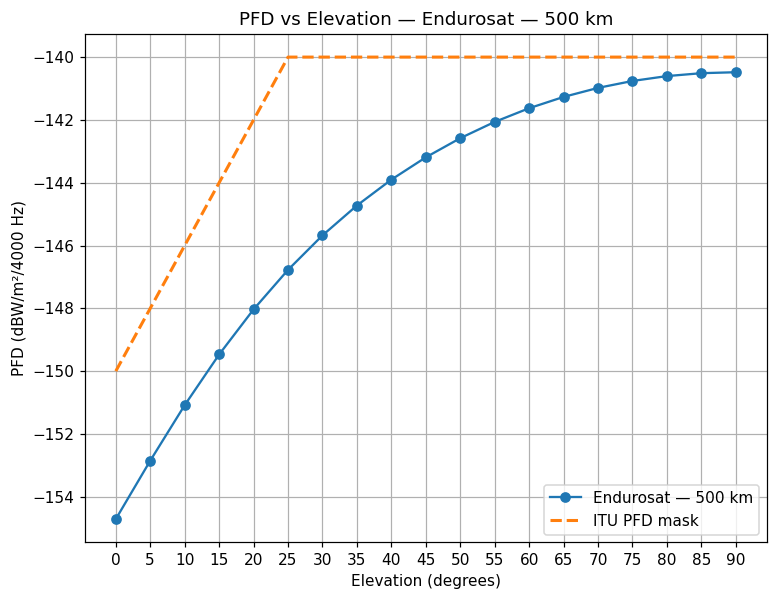

[info] Mask overlay saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_500km_pfd_vs_elevation_step5__with_mask.png


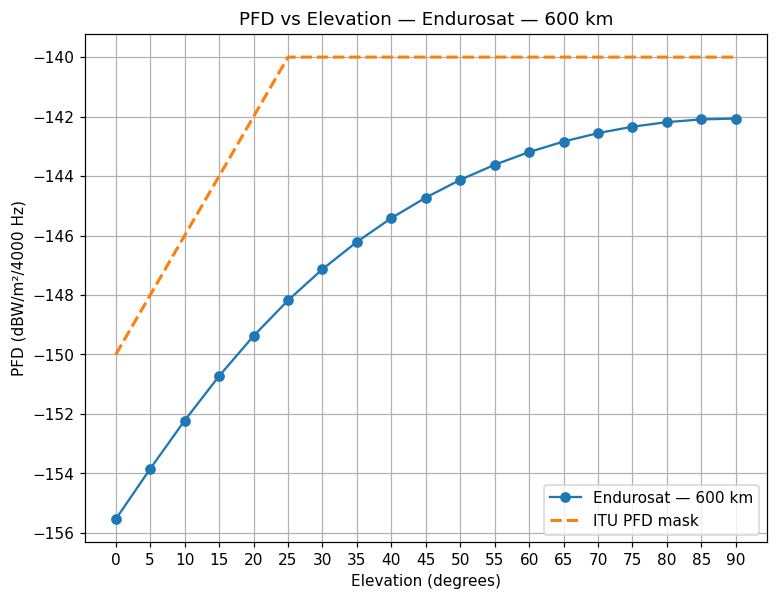

[info] Mask overlay saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_600km_pfd_vs_elevation_step5__with_mask.png


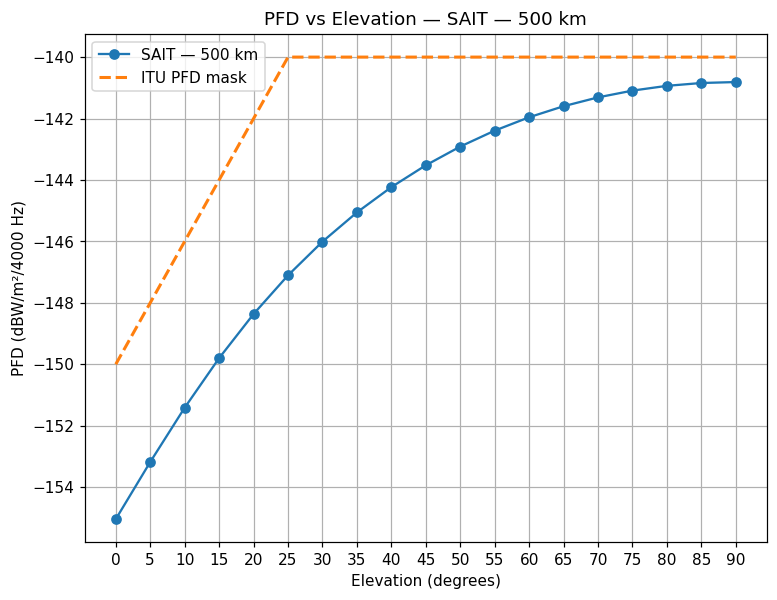

[info] Mask overlay saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_500km_pfd_vs_elevation_step5__with_mask.png


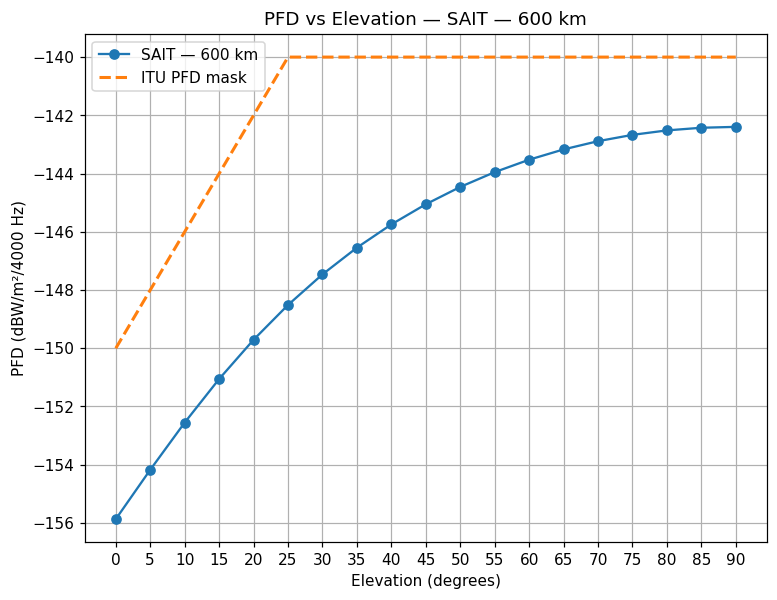

[info] Mask overlay saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_600km_pfd_vs_elevation_step5__with_mask.png


In [21]:

# --- Configuration (edit these) ---
COMBINED_CSV_CANDIDATES = [
    OUTPUT_DIR / "all_radios_link_PFD_vs_elevation_step5__custom_losses.csv",
    OUTPUT_DIR / "all_radios_link_PFD_vs_elevation_step5.csv",
    Path("all_radios_link_PFD_vs_elevation_step5__custom_losses.csv"),
    Path("all_radios_link_PFD_vs_elevation_step5.csv"),
]

# Plot bandwidth (set this to the unit you want on the Y-axis, e.g., 4000 for 4 kHz, 24000 for 24 kHz)
pfd_plot_bw_hz = 4000  # default 4 kHz
# ITU mask: piecewise-linear points of (elevation_deg, pfd_limit).
mask_units = "integrated"   # "per_MHz" or "integrated"
channel_bw_hz = pfd_plot_bw_hz     # e.g., 8e6 for 8 MHz. If your plotted PFD is already per MHz, leave as None.

# TODO: Replace with the correct ITU mask for your band/service.
# Placeholder example (flat line): -118 dBW/m^2 per MHz across all elevations.
itu_mask_points = [
    (0.0,  -150.0),
    (25.0, -140.0),
    (90.0, -140.0),
]

# --- Don't edit below unless needed ---
import math
import pandas as pd
import matplotlib.pyplot as plt

def _find_csv(path_list):
    for p in path_list:
        if Path(p).is_file():
            return Path(p)
    raise FileNotFoundError("Combined CSV not found. Run the previous cells to generate it, or update COMBINED_CSV_CANDIDATES.")

def _mask_xy(points, mask_units="per_MHz", channel_bw_hz = pfd_plot_bw_hz):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    if mask_units == "per_MHz" and channel_bw_hz:
        ys = [y + 10*math.log10(channel_bw_hz/1e6) for y in ys]
    return xs, ys

combined_csv = _find_csv(COMBINED_CSV_CANDIDATES)
dfc = pd.read_csv(combined_csv)

# Try to detect column names
col_radio = None
for c in ["radio", "radio_name", "name", "Radio"]:
    if c in dfc.columns:
        col_radio = c; break
if col_radio is None:
    raise KeyError(f"Could not find a radio name column in {combined_csv}. Tried common names. Columns: {list(dfc.columns)}")

if "elevation_deg" not in dfc.columns or "pfd_dbw_per_m2" not in dfc.columns:
    raise KeyError("CSV must contain 'elevation_deg' and 'pfd_dbw_per_m2'.")

alts = sorted(dfc["orbit_altitude_km"].unique()) if "orbit_altitude_km" in dfc.columns else [None]

for radio_name, g in dfc.groupby(col_radio):
    for alt in alts:
        sub = g if alt is None else g[g.get("orbit_altitude_km") == alt]
        if sub.empty:
            continue
        sub = sub.sort_values("elevation_deg")

        plt.figure(figsize=(8, 6))
        pfd_to_plot = sub["pfd_dbw_per_m2"] - 10*math.log10(max(pfd_plot_bw_hz,1))
        plt.plot(sub["elevation_deg"], pfd_to_plot, marker="o", label=f"{radio_name}{"" if alt is None else f" — {int(alt)} km"}")

        mx, my = _mask_xy(itu_mask_points, mask_units=mask_units, channel_bw_hz=channel_bw_hz)
        plt.plot(mx, my, linestyle="--", linewidth=2, label="ITU PFD mask")

        plt.title(f"PFD vs Elevation — {radio_name}{'' if alt is None else f' — {int(alt)} km'}")
        plt.xlabel("Elevation (degrees)"); plt.ylabel(f"PFD (dBW/m²/{int(pfd_plot_bw_hz)} Hz)")
        if 'ELEV_STEP_DEG' in globals():
            plt.xticks(list(range(0, 91, int(ELEV_STEP_DEG))))
        plt.grid(True); plt.legend()

        # Save alongside originals, tagged with _with_mask
        base = f"{radio_name}".replace(' ', '_')
        if alt is not None:
            base += f"_{int(alt)}km"
        out_png = OUTPUT_DIR / f"{base}_pfd_vs_elevation_step5__with_mask.png"
        plt.savefig(out_png, bbox_inches="tight")
        plt.show()
        print(f"[info] Mask overlay saved -> {out_png.resolve()}")


In [22]:
# --- Single notebook cell: Endurosat X-band data volume vs pass duration (500/600 km) ---
# Requires: x_down_info.csv in the working directory. Produces a plot + CSV.
#
# This cell:
#   1) Reads Endurosat 'supported_user_data_rate' from x_down_info.csv (falls back to channel_throughput*(1-overhead)).
#   2) Uses your earlier 600 s results to infer per-altitude efficiencies:
#        - 500 km: 5905.5 MB over 600 s
#        - 600 km: 4738.2 MB over 600 s
#   3) Builds a table for 5–10 minute passes and plots the data (MB per pass).
#
# You can tweak: USER_MB_600_500, USER_MB_600_600, MIN_MINUTES, MAX_MINUTES.

import math
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "x_down_info.csv"  # adjust if needed
VENDOR = "Endurosat"

# User-provided per-600s volumes (MB):
USER_MB_600_500 = 5905.5
USER_MB_600_600 = 4738.2

MIN_MINUTES = 5
MAX_MINUTES = 10

def _get_numeric(value):
    if isinstance(value, str) and value.strip().endswith('%'):
        return float(value.strip().rstrip('%')) / 100.0
    try:
        return float(value)
    except Exception:
        return math.nan

def read_endurosat_rate_mbps(csv_path: str, vendor: str = "Endurosat") -> float:
    df = pd.read_csv(csv_path)
    if "python_variable" not in df.columns:
        raise ValueError("CSV must contain a 'python_variable' column.")
    # Prefer supported_user_data_rate if present and finite
    if (df["python_variable"] == "supported_user_data_rate").any():
        v = df.loc[df["python_variable"] == "supported_user_data_rate", vendor].iloc[0]
        val = _get_numeric(v)
        if math.isfinite(val):
            return val
    # Fallback to channel_throughput * (1 - overhead)
    ch = df.loc[df["python_variable"] == "channel_throughput", vendor].iloc[0]
    ch_val = _get_numeric(ch)
    if (df["python_variable"] == "other_radio_protocol_overheads").any():
        oh = df.loc[df["python_variable"] == "other_radio_protocol_overheads", vendor].iloc[0]
        oh_val = _get_numeric(oh)
        if oh_val > 1:
            oh_val = oh_val / 100.0
    else:
        oh_val = 0.0
    return ch_val * (1 - (oh_val or 0.0))

rate_mbps = read_endurosat_rate_mbps(CSV_PATH, VENDOR)

# Baseline MB at 600 s (no extra losses)
baseline_mb_600 = rate_mbps * 600.0 / 8.0

# Efficiencies to match user's figures
eff_500 = USER_MB_600_500 / baseline_mb_600 if baseline_mb_600 else float('nan')
eff_600 = USER_MB_600_600 / baseline_mb_600 if baseline_mb_600 else float('nan')

minutes = list(range(MIN_MINUTES, MAX_MINUTES + 1))
rows = []
for m in minutes:
    seconds = m * 60.0
    mb_no_eff = rate_mbps * seconds / 8.0
    mb_500 = mb_no_eff * eff_500
    mb_600 = mb_no_eff * eff_600
    rows.append({
        "Pass (min)": m,
        "MB (no losses)": round(mb_no_eff, 1),
        "500 km (MB)": round(mb_500, 1),
        "600 km (MB)": round(mb_600, 1),
    })

table = pd.DataFrame(rows)
try:
    from IPython.display import display
    display(table)
except Exception:
    print(table.to_string(index=False))

# Plot
plt.figure()
plt.plot(table["Pass (min)"], table["500 km (MB)"], marker="o", label="500 km")
plt.plot(table["Pass (min)"], table["600 km (MB)"], marker="s", label="600 km")
plt.xlabel("Pass duration (minutes)")
plt.ylabel("Data per pass (MB)")
plt.title("X-band downlink data volume vs. pass duration (Endurosat)")
plt.legend()
plt.tight_layout()

# Save outputs
out_csv = "xband_pass_duration_data_volume.csv"
out_png = "xband_pass_duration_data_volume.png"
table.to_csv(out_csv, index=False)
plt.savefig(out_png)

print(f"Saved: {out_csv}, {out_png}")
print(f"Rate (Mbps): {rate_mbps:.3f} | Eff500: {eff_500:.3f} | Eff600: {eff_600:.3f}")


,Pass (min),MB (no losses),500 km (MB),600 km (MB)
0,5,3337.5,2952.8,2369.1
1,6,4005.0,3543.3,2842.9
2,7,4672.5,4133.9,3316.7
3,8,5340.0,4724.4,3790.6
4,9,6007.5,5314.9,4264.4
5,10,6675.0,5905.5,4738.2


Saved: xband_pass_duration_data_volume.csv, xband_pass_duration_data_volume.png
Rate (Mbps): 89.000 | Eff500: 0.885 | Eff600: 0.710
